In [1]:
%matplotlib inline
!pip install braindecode
!pip install utils
!pip install git+https://github.com/sylvchev/beetl-competition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 184 kB 4.7 MB/s 
     |████████████████████████████████| 193 kB 52.4 MB/s 
     |████████████████████████████████| 7.6 MB 56.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/sylvchev/beetl-competition to /tmp/pip-req-build-xwvdrwgj
  Running command git clone -q https://github.com/sylvchev/beetl-competition /tmp/pip-req-build-xwvdrwgj
     |████████████████████████████████| 46 kB 2.3 MB/s 
     |████████████████████████████████| 6.9 MB 9.5 MB/s 
     |████████████████████████████████| 140 kB 63.3 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 662 kB 59.6 MB/s 
     |████████████████████████████████| 245 kB 51.9 M

In [2]:
from braindecode.util import set_random_seeds
from braindecode.util import np_to_var, var_to_np
import matplotlib.pyplot as plt 
import numpy as np
from numpy.random import RandomState
import os.path as osp
import pickle
import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from beetl.task_datasets import BeetlSleepTutorial
import mne
import scipy.stats as sps
import pandas as pd
import random
from sklearn.datasets import make_blobs
import seaborn as sns


In [3]:
dataset = BeetlSleepTutorial()
x,y,info = dataset.get_data()
raw = dataset.get_data()


MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


/usr/local/lib/python3.8/dist-packages/moabb/datasets/download.py:53: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BEETLSLEEPTUTORIAL_PATH"
  set_config(key, get_config("MNE_DATA"))
100%|███████████████████████████████████████| 152M/152M [00:00<00:00, 12.9GB/s]
Unzipping contents of '/root/mne_data/MNE-beetlsleeptutorial-data/28579419' to '/root/mne_data/MNE-beetlsleeptutorial-data/28579419.unzip'


[ 8.11135531e-06  1.74886447e-05  2.12395604e-05 ... -1.03619048e-05
 -1.11120879e-05 -2.10989011e-06]
(9850,)


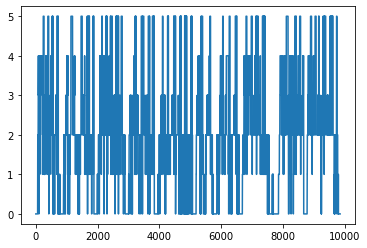

In [4]:
plt.plot(y)
print(x[0][0])
print(y.shape)

In [5]:
# given a time-series data, calculate it's rowing average based on a given window size
# helper function for tokenize_array
def rowing_average(arr,window_size=10):
  #np.convolve(cur_data, np.ones(frame_size), 'valid') / frame_size
  count = 0
  moving_averages = []
  i = 0
  while i < len(arr) - window_size + 1:
      

      window = arr[i : i + window_size]
    
      window_average = (sum(window) / window_size)
        
      moving_averages.append(window_average)
        
      i += window_size
  return moving_averages

# Given a time-series data, standardize it to mean = 0 and sd = 1
# helper function for tokenize_array
def guassian_normalize(arr):
  mean = sum(arr)/len(arr)
  sd = np.std(arr)
  return (arr-mean)/sd

# Given a number bound n, calculate the cutoffs for n equal area sections under the normal distribution
# helper function for tokenize_array
def calculate_breakpoints(n):
  mu = 0
  sigma = 1
  splits = n

  # define the normal distribution and PDF
  dist = sps.norm(loc=mu, scale=sigma)
  x = np.linspace(dist.ppf(.001), dist.ppf(.999))
  y = dist.pdf(x)

  # calculate PPFs
  step = 1 / splits
  quantiles = np.arange(step, 1.0 - step / 2, step)
  ppfs = dist.ppf(quantiles)  # boundaries
  return ppfs

# given the time-series data and breakpoint cutoffs, tokenize the input 
# helper function for tokenize_array
def tokenize(arr,breakpoints):
  key = ['c'+str(i+1) for i in range(len(breakpoints)+1)]
  test = {k:[] for k in key}

  tokenized_array = []
  for i in arr:
    j = 0
    while j < len(breakpoints) and i > breakpoints[j] :
      j+=1
    #print(j,i,key[j-1])
    tokenized_array.append(key[j-1])
    test[key[j-1]].append(i)
  return tokenized_array,test

    


In [6]:
# general function for tokenizing time-series data
def tokenize_array(data, frame_size = 10, breakpoint_num = 10):
  normalized = guassian_normalize(data)        
  PAA = rowing_average(normalized,frame_size)
  breakpoints = calculate_breakpoints(breakpoint_num)
  ret,test = tokenize(PAA,breakpoints)
  pd.Series(ret).value_counts(sort=False).plot(kind='bar')
  return ret,test

# reconstruct the normalized and PAA array 
def reconstruct(tokenized_data, value_dict):
  average = {}
  restored_data = []
  for key,value in value_dict.items():  #calculate mean per token
    mean = sum(value)/len(value)
    average.update({key:mean})
  
  for data in tokenized_data:
    restored_data.append(average[data])
  return restored_data

def compare_diff(Y_pred,Y_true):
  x = np.arange(0,len(Y_pred),1)
  plt.plot(x,Y_true,label = 'Original')
  plt.plot(x,Y_pred, label = 'Restored')
  plt.legend()
  plt.show()

  mse = np.square(np.subtract(Y_true,Y_pred)).mean()
  r_sqrd = 1 - mse/np.var(Y_true)
  # print('mse: ',mse)
  # print('r^2: ',r_sqrd)
  return mse,r_sqrd



['c5', 'c4', 'c5', 'c4', 'c5', 'c5']
{'c1': [], 'c2': [], 'c3': [], 'c4': [-0.02848040445069183, -0.10939516928946343], 'c5': [0.013401837755075764, 0.020706043225669296, 0.01415024895600361, 0.08961744380340664], 'c6': [], 'c7': [], 'c8': [], 'c9': [], 'c10': []}


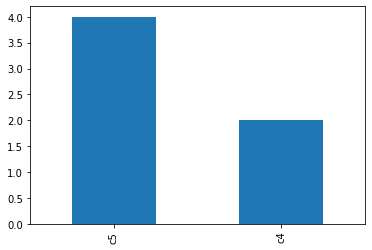

In [7]:
cur_data = x[1][0]
a, test = tokenize_array(cur_data,500,10)
print(a)
print(test)

In [8]:
res = reconstruct(a,test)
ori = rowing_average(cur_data,10)
ori = guassian_normalize(ori)
compare_diff(res,ori)


ZeroDivisionError: ignored

In [ ]:
print(x.shape)
result_mse = []
result_rsqrd = []

for i in range(500):
  curr_data = x[i][0]
  a, test = tokenize_array(curr_data,10,15)
  res = reconstruct(a,test)
  ori = rowing_average(curr_data,10)
  ori = guassian_normalize(ori)
  mse,rsqrd = compare_diff(res,ori)
  result_mse.append(mse)
  result_rsqrd.append(rsqrd)

x = np.arange(0,500,1)
plt.plot(x,result_mse,label = 'mse')
plt.plot(x,result_rsqrd, label = 'r^2')
plt.legend()
plt.show()


In [ ]:

plt.boxplot(result_mse)
plt.title('MSE')
plt.show()
plt.title('r^2')
plt.boxplot(result_rsqrd)
plt.show()

In [ ]:
#calculate a distance mapping given the amount of breakpoints
def distance_mapping(breakpoint_num):
  bpoint_array = calculate_breakpoints(breakpoint_num)
  mapping = np.zeros((breakpoint_num,breakpoint_num))
  
  for i in range((breakpoint_num)):
    for j in range((breakpoint_num)):
      r = i 
      c = j 
      if abs(r-c)<= 1:
        mapping[i][j] = 0
       
      else:
        beta_max = bpoint_array[max(r,c)-1]
        beta_min = bpoint_array[min(r,c)]
        mapping[i][j] = beta_max - beta_min

  # mapping = np.array(mapping)
  # mapping = np.transpose(mapping)
  for i in range(len(mapping)):
    print(mapping[i])
 

  return mapping

def distance(point1,point2,mapping):
  p1 = int(point1[1:])-1
  p2 = int(point2[1:])-1
  return mapping[p1][p2]


a = distance_mapping(5) 



In [ ]:
def euclidean(point, data, bnum):
  mapping = distance_mapping(bnum)
  ret = []
  for i in range(data.shape[0]):
    cur_iter = 0
    for j in range(len(data[i])):
      cur_iter += distance(point[j],data[i][j],mapping)
    ret.append(cur_iter)
  return ret

class KMeans:
    def __init__(self, bnum, n_clusters=4, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.bnum = bnum
        
    def fit(self, X_train):
        # Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first,
        # then the rest are initialized w/ probabilities proportional to their distances to the first
        # Pick a random point from train data for first centroid
        self.centroids = [random.choice(X_train)]
        for _ in range(self.n_clusters-1):
            # Calculate distances from points to the centroids
            dists = np.sum([euclidean(centroid, X_train, self.bnum) for centroid in self.centroids], axis=0)
            # Normalize the distances
            dists /= np.sum(dists)
            # Choose remaining points based on their distances
            new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
            self.centroids += [X_train[new_centroid_idx]]
        # Iterate, adjusting centroids until converged or until passed max_iter
        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # Sort each datapoint, assigning to nearest centroid
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            # Push current centroids to previous, reassign centroids as mean of the points belonging to them
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                    self.centroids[i] = prev_centroids[i]
            iteration += 1
    def evaluate(self, X):
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        return centroids, centroid_idxs


In [ ]:
# Create a dataset of 2D distributions
centers = 4
x,y,info = dataset.get_data()
X_train = []

for i in range(5000):
  curr_data = x[i][0]
  a, test = tokenize_array(curr_data,10,15)
  X_train.append(a)
X_train = np.array(X_train)
true_labels = y[0:5000]
# Fit centroids to dataset
kmeans = KMeans(bnum = 4,n_clusters=centers)
kmeans.fit(X_train)

# View results
class_centers, classification = kmeans.evaluate(X_train)
sns.scatterplot(x=[X[0] for X in X_train],
                y=[X[1] for X in X_train],
                hue=true_labels,
                style=classification,
                palette="deep",
                legend=None
                )
plt.plot([x for x, _ in kmeans.centroids],
         [y for _, y in kmeans.centroids],
         'k+',
         markersize=10,
         )
plt.show()